# Evidence of Reasonable Models - kNN

We perform a set of experiments to see if the data is classifiable and can be differentiated in the catgories mentioned. In this file, we use the kNN classifier to study the data.

The following sections present our process of extracting the combined dataset (combination of data done in data_preprocessing.ipynb) from the relvant train and test files. The train and test split has been pre-done by using _train_test_split_ and stored in the train and test folders. We also have a subset of unseen drivers filtered out from the data, to measure how well our model can generalise to the population, i.e., to drivers it hasn't seen before. We sample out 1022 images from the train set consisting of 10225 images and use this randomly generated, label stratified sample for our experiments. The images are preporcessed to extract the figure of the driver and set all the surroundings to black. This preprocessed data is then fed into the model, hyperparameters are tuned and the final best model is tested against a randomly generated stratified sample of test data. The results are presented as a classification report and a confusion matrix. 

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, get_scorer_names
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import torch
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision import transforms
from sklearn.decomposition import PCA
from pickle import dump, load

# If you do not have a GPU or do not want to run this code on your GPU, comment out the following lines
torch.cuda.empty_cache()
torch.cuda.is_available()

True

## Extracting the Data

The images stored in the CombinedNew zip file are extracted into separate train and test set paths.

Note: Please have the 'CombinedNew.zip' file in the same folder as this notebook.

In [4]:
# from zipfile import ZipFile
# password = "57Rk!F8yUz38"
# with ZipFile('CombinedNew.zip') as zipObj:
#   zipObj.extractall(pwd=bytes(password, 'utf-8'))

In [3]:
PARENT_PATH = os.getcwd()
DATA_PATH = os.path.join(os.getcwd(), "../Data/Combined New")
TEST_PATH = os.path.join(DATA_PATH, "test")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
UNSEEN_PATH = os.path.join(DATA_PATH, "unseen")
NUM_CLASSES = 8
TRAIN_PATH

'c:\\Users\\wamik\\Documents\\Notes Y4S2\\CS3244\\Projects\\Project 2\\CS3244-Group-8-Project-2\\Combined New\\train'

In [4]:
CLASS = [["c0", "Safe Driving"], ["c1", "Text"], ["c2", "Phone"], 
         ["c3", "Adjusting Radio"], ["c4", "Drinking"], 
         ["c5", "Reaching Behind"], ["c6", "Hair or Makeup"], 
         ["c7", "Talking to Passenger"]]
TEST_CLS = [os.path.join(os.getcwd(), TEST_PATH, cls[0]) for cls in CLASS]
TRAIN_CLS = [os.path.join(os.getcwd(), TRAIN_PATH, cls[0]) for cls in CLASS]
for cls_path in TEST_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))
for cls_path in TRAIN_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))

c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c0
711
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c1
667
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c2
602
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c3
264
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c4
255
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c5
243
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c6
242
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c7
430
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\trai

For each class, the path of the training and test data is stored in separate lists. The corresponding labels are also stored in a different list

In [5]:
train_paths = []
test_paths = []
for cls in range(NUM_CLASSES):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    train_paths.append(os.path.join(TRAIN_CLS[cls], train_instance))
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_paths.append(os.path.join(TEST_CLS[cls], test_instance))

In [6]:
classes = []
test_classes = []
for cls in range(NUM_CLASSES):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    classes.append(cls)
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_classes.append(cls)

Then separate dataframes storing the train and test paths with their corresponding labels are created.

In [7]:
df = pd.DataFrame({
  'filename': train_paths,
  'class': classes
})
df

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
10220,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
10221,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
10222,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
10223,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


In [8]:
df_test = pd.DataFrame({
  'filename': test_paths,
  'class': test_classes
})
df_test

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
3409,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
3410,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
3411,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
3412,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


The below plots show us the frequency of each class in the dataset. As can be seen from the plots, the dataset is not balanced. Keeping this in mind, we use evaluation metrics like recall and precision along with accuracy to get better insights on performance.

<AxesSubplot:>

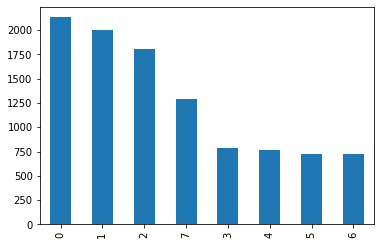

In [9]:
df['class'].value_counts().plot.bar()

<AxesSubplot:>

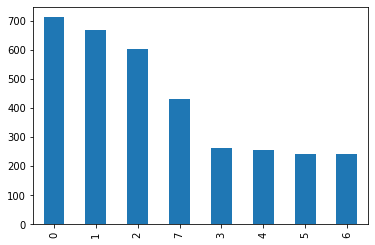

In [10]:
df_test['class'].value_counts().plot.bar()

In [11]:
df_all_data = pd.concat([df, df_test], ignore_index=True)
df_all_data

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
13634,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
13635,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
13636,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
13637,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


## Data Preprocessing

First, we convert the images from RGB to Gray and then perform appropriate resizing based on a calculated scale. 

**Note: The code in this section  needs to be run only once. If you already have "processed_imgs.npy", and "labels.npy", DO NOT run this section. Skip to [Loading Final Data](#loading-final-data)**

We now perform a similar process on all sets of the training data. Before doing so, we first convert the images into 2D pixels with the appropriate color to gray transformation and resizing. This is done so that the 1255 samples can be randomly selected using _train_test_split()_.

In [12]:
X_train_final = []
Y_train = []
for index, path in df.iterrows():
    img_orig = cv2.imread(path[0], cv2.COLOR_RGB2GRAY)
    k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
    img = cv2.resize(img_orig, (340, 210), fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)
    if (index+1) % 135 == 0:
        print("Processed ", index + 1, "images. Continuing...")
    X_train_final.append(np.asarray(img))
    Y_train.append(path[1])

print("Done!")

Processed  135 images. Continuing...
Processed  270 images. Continuing...
Processed  405 images. Continuing...
Processed  540 images. Continuing...
Processed  675 images. Continuing...
Processed  810 images. Continuing...
Processed  945 images. Continuing...
Processed  1080 images. Continuing...
Processed  1215 images. Continuing...
Processed  1350 images. Continuing...
Processed  1485 images. Continuing...
Processed  1620 images. Continuing...
Processed  1755 images. Continuing...
Processed  1890 images. Continuing...
Processed  2025 images. Continuing...
Processed  2160 images. Continuing...
Processed  2295 images. Continuing...
Processed  2430 images. Continuing...
Processed  2565 images. Continuing...
Processed  2700 images. Continuing...
Processed  2835 images. Continuing...
Processed  2970 images. Continuing...
Processed  3105 images. Continuing...
Processed  3240 images. Continuing...
Processed  3375 images. Continuing...
Processed  3510 images. Continuing...
Processed  3645 ima

In [13]:
print(len(Y_train))

10225


In [14]:
data_arr = np.asarray(X_train_final)
print(data_arr.shape)
data_arr = data_arr.reshape(data_arr.shape[0], -1)
labels_arr = np.asarray(Y_train)

(10225, 210, 340, 3)


In [15]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data_arr, labels_arr, test_size=0.9, stratify=labels_arr, random_state=42)
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
print(X_train.shape)
print(Y_train.shape)

(1022, 214200)
(1022,)


We reduce the dimensions of the data using Principal Component Analysis (PCA).

In [16]:
pca_dims = PCA()
pca_dims.fit(X_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [17]:
d

267

In [18]:
pca = PCA(n_components=d)
X_train_reduced = pca.fit_transform(X_train)

**Create a knn folder in the Data folder before running any of the cells below.**

In [19]:
np.save("../Data/knn/processed_imgs.npy", X_train_reduced)
np.save("../Data/knn/labels.npy", Y_train)

In [20]:
dump(pca, open('pca_knn.pkl', 'wb'))

## Loading Final Data

Note: Ensure that the below files being loaded are in the same location as this notebook.

In [32]:
Y_train = np.load("../Data/knn/labels.npy")
X_train_final = np.load("../Data/knn/processed_imgs.npy")
X_train_final.shape

(1022, 267)

## kNN Model

We choose to do trial and error for choosing the best hyperparameters due to the nature of the data. The training set has drivers that the model has already seen, hence doing a validation split on the training set may result in overfitting to drivers' facial features.

In [23]:
print(get_scorer_names())
parameters_knn = {'n_neighbors': range(5, 25), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'chebyshev', 'manhattan']}

clf_knn = GridSearchCV(KNeighborsClassifier(), param_grid=parameters_knn, cv=5, n_jobs=-1, scoring="f1_weighted", verbose=10)

clf_knn.fit(X=X_train_final, y=Y_train)

print ("The best f1 score for KNN:", clf_knn.best_score_ * 100, "%, with", clf_knn.best_params_) 

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 

In [33]:
clf_knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', metric='manhattan')
clf_knn.fit(X_train_final, Y_train)
print(clf_knn.classes_)

[0 1 2 3 4 5 6 7]


## Performance Evaluation

### Preparing Test Data

Test data is prepared in the same manner as the training data. Run this section ONLY ONCE to generate the .npy files.

**Note: if you have the "test_data.npy" and "test_labels.npy" files, DO NOT run this section, skip to [Evaluating Performance](#evaluating-performance) section.**

In [27]:
X_test_processed = []
Y_test = []
for index, path in df_test.iterrows():
    img_orig = cv2.imread(path[0], cv2.COLOR_RGB2GRAY)
    if img_orig is not None:
        k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
        img = cv2.resize(img_orig, (340, 210), fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)
        if (index+1) % 135 == 0:
            print("Processed ", index + 1, "images. Continuing...")
        X_test_processed.append(np.asarray(img))
        Y_test.append(path[1])

print("Done!")

Processed  135 images. Continuing...
Processed  270 images. Continuing...
Processed  405 images. Continuing...
Processed  540 images. Continuing...
Processed  675 images. Continuing...
Processed  810 images. Continuing...
Processed  945 images. Continuing...
Processed  1080 images. Continuing...
Processed  1215 images. Continuing...
Processed  1350 images. Continuing...
Processed  1485 images. Continuing...
Processed  1620 images. Continuing...
Processed  1755 images. Continuing...
Processed  1890 images. Continuing...
Processed  2025 images. Continuing...
Processed  2160 images. Continuing...
Processed  2295 images. Continuing...
Processed  2430 images. Continuing...
Processed  2565 images. Continuing...
Processed  2700 images. Continuing...
Processed  2835 images. Continuing...
Processed  2970 images. Continuing...
Processed  3105 images. Continuing...
Processed  3240 images. Continuing...
Processed  3375 images. Continuing...
Done!


In [28]:
tdata_arr = np.asarray(X_test_processed)
print(tdata_arr.shape)
tdata_arr = tdata_arr.reshape(tdata_arr.shape[0], -1)
tlabels_arr = np.asarray(Y_test)

(3413, 210, 340, 3)


In [29]:
(X_train, X_test, Y_train, Y_test) = train_test_split(tdata_arr, tlabels_arr, test_size=0.1, stratify=tlabels_arr, random_state=42)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
print(X_test.shape)
print(Y_test.shape)

(342, 214200)
(342,)


In [30]:
X_test_final = pca.transform(X_test)
np.save("../Data/knn/test_data.npy", X_test_final)
np.save("../Data/knn/test_labels.npy", Y_test)

### Evaluating Performance on Test Data

Since accuracy may not be the best indicator of model performance due to the imbalance in the dataset, we also use confusion matrix and classification report to further support our analysis.

Note: Ensure that the below files being loaded are in the same location as this notebook.

In [34]:
X_test_processed = np.load("../Data/knn/test_data.npy")
Y_test = np.load("../Data/knn/test_labels.npy")
X_test_processed.shape

(342, 267)

In [35]:
print(clf_knn.score(X_test_processed, Y_test))
predictions = clf_knn.predict(X_test_processed)

0.6666666666666666


In [36]:
Y_test_new = []
for l in Y_test:
    if l!=0:
        Y_test_new.append(1)
    else:
        Y_test_new.append(0)
predictions_new = []
for pred in predictions:
    if pred!=0:
        predictions_new.append(1)
    else:
        predictions_new.append(0)

In [37]:
print(classification_report(Y_test_new, predictions_new))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68        71
           1       0.92      0.91      0.91       271

    accuracy                           0.87       342
   macro avg       0.79      0.80      0.80       342
weighted avg       0.87      0.87      0.87       342



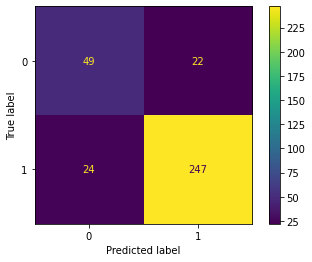

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


cm_knn = confusion_matrix(Y_test_new, predictions_new, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=[0, 1])  
disp.plot()

              precision    recall  f1-score   support

           0       0.67      0.69      0.68        71
           1       0.67      0.72      0.69        67
           2       0.61      0.77      0.68        60
           3       1.00      0.85      0.92        27
           4       0.79      0.58      0.67        26
           5       0.73      0.46      0.56        24
           6       0.35      0.29      0.32        24
           7       0.66      0.67      0.67        43

    accuracy                           0.67       342
   macro avg       0.68      0.63      0.65       342
weighted avg       0.67      0.67      0.66       342



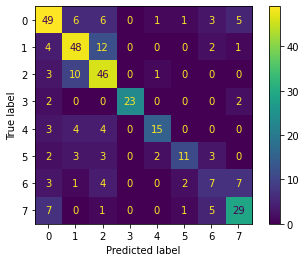

In [39]:
print(classification_report(Y_test, predictions))
cm_knn = confusion_matrix(Y_test, predictions, labels=clf_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=clf_knn.classes_)  
disp.plot()

### Preparing Unseen Drivers Data

We will now evaluate model performance on drivers it hasn't seen before. First, we prepare the data for evaluation.

In [40]:
UNSEEN_CLS = [os.path.join(os.getcwd(), UNSEEN_PATH, cls[0]) for cls in CLASS]
for cls_path in UNSEEN_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))

unseen_paths = []
for cls in range(NUM_CLASSES):
  for unseen_instance in os.listdir(UNSEEN_CLS[cls]):
    unseen_paths.append(os.path.join(UNSEEN_CLS[cls], unseen_instance))

unseen_classes = []
for cls in range(NUM_CLASSES):
  for unseen_instance in os.listdir(UNSEEN_CLS[cls]):
    unseen_classes.append(cls)

df_unseen = pd.DataFrame({'filename': unseen_paths, "class": unseen_classes})
df_unseen

c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\unseen\c0
145
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\unseen\c1
175
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\unseen\c2
169
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\unseen\c3
68
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\unseen\c4
59
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\unseen\c5
65
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\unseen\c6
79
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\unseen\c7
80


,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
835,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
836,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
837,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
838,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


In [44]:
X_unseen = []
Y_unseen = []
for index, path in df_unseen.iterrows():
    if not (".DS_Store" in path[0]):
        img_orig = cv2.imread(path[0], cv2.COLOR_RGB2GRAY)
        k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
        img = cv2.resize(img_orig, (340, 210), fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)
        if (index+1) % 135 == 0:
            print("Processed ", index + 1, "images. Continuing...")
        X_unseen.append(np.asarray(img))
        Y_unseen.append(path[1])

print("Done!")

Processed  135 images. Continuing...
Processed  270 images. Continuing...
Processed  405 images. Continuing...
Processed  540 images. Continuing...
Processed  675 images. Continuing...
Processed  810 images. Continuing...
Done!


In [47]:
X_unseen = np.asarray(X_unseen)
X_unseen = X_unseen.reshape(X_unseen.shape[0], -1)
Y_unseen = np.asarray(Y_unseen)
X_unseen.shape

(839, 214200)

In [49]:
pca = load(open('pca_knn.pkl', 'rb'))
X_unseen_final = pca.transform(X_unseen)
X_unseen_final.shape

(839, 267)

In [52]:
print(clf_knn.score(X_unseen_final, Y_unseen))
predictions_unseen = clf_knn.predict(X_unseen_final)

0.19904648390941598


              precision    recall  f1-score   support

           0       0.22      0.08      0.11       144
           1       0.17      0.17      0.17       175
           2       0.22      0.14      0.17       169
           3       0.49      0.46      0.47        68
           4       0.10      0.17      0.12        59
           5       0.26      0.32      0.29        65
           6       0.11      0.01      0.02        79
           7       0.16      0.49      0.24        80

    accuracy                           0.20       839
   macro avg       0.22      0.23      0.20       839
weighted avg       0.21      0.20      0.18       839



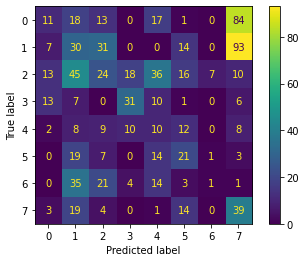

In [53]:
print(classification_report(Y_unseen, predictions_unseen))
cm_knn_unseen = confusion_matrix(Y_unseen, predictions_unseen, labels=clf_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn_unseen,
                               display_labels=clf_knn.classes_)  
disp.plot()